In [1]:
#%matplotlib notebook
import time, winsound, h5py, os
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

In [3]:
def define_devices(
    f1, f2, slit_width = 500e-6, alphaAsym = np.deg2rad(27.98), E0=E0, f0 = 290., d23=7.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=f2, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1.z+.1,N=256,FOV=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2, FOV=100e-6, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2 + 1e-3, x_width=slit_width, y_width=2e-3)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
                              asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, focus, slit, crl2, crystal3, crystal4, im2]

    return devices

In [4]:
%%capture capt
tstart = time.time()
# initialize optical elements
f1 = 9.775183946488294
f2 = 10.

devices = define_devices(f1, f2)

# initialize beamline
mono_beamline = beamline.Beamline(devices)

for oe in devices:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))

# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=2500)
pulse.propagate(beamline=mono_beamline, screen_names=['focus','im2'])
tfin = time.time()

In [5]:
print('each run: {}s, per slice: {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))
''' energy slices '''

each run: 4.75s, per slice: 84.84ms


' energy slices '

### Loops

In [6]:
%%capture capt
tstart = time.time()
new_run = 0
N1 = 60
N2 = 50
#N1 = 2
#N2 = 2
f1_list = np.linspace(-0.05, 0.05, N1)+f1
f0_list = np.linspace(-7.5,7.5,N2)+290.

duration = np.zeros((N1,N2))
tilt = np.zeros_like(duration)
bw = np.zeros_like(duration)
throughput = np.zeros_like(duration)
cent_E = np.zeros_like(duration)

if new_run == 1:
    for i, f1_ in enumerate(f1_list):
        for j, f0_ in enumerate(f0_list):
            # pulse duration and tilt
            slit_width = 100e-6
            devices = define_devices(f1_, f2, f0=f0_, slit_width = slit_width)
            # initialize beamline
            mono_beamline = beamline.Beamline(devices)
            # reset central photon energy
            beam_params['photonEnergy'] = E0

            # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
            pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=2500)

            print('Number of spectral components: {:d}'.format(pulse.N))
            pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
            centroid, duration[i,j] = pulse.pulse_duration('im2')
            tilt[i,j] = pulse.pulsefront_tilt('im2')

            # else (closed slit)
            slit_width = 7e-6
            devices = define_devices(f1_, f2, f0=f0_, slit_width = slit_width)
            mono_beamline = beamline.Beamline(devices)
            beam_params['photonEnergy'] = E0
            pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=2500)
            pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
            bw[i,j] = pulse.pulse_bandwidth('im2')
            throughput[i,j] = pulse.throughput('im0','im2')
            cent_E[i,j] = pulse.central_energy('im2')
tfin = time.time()


In [7]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'compensation_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

if new_run == 1:
    os.remove(fig_path+fname+'.h5')  
    with h5py.File(fig_path+fname+'.h5','w') as f:
        f.create_dataset('f1', data=f1_list)
        f.create_dataset('f0', data=f0_list)
        f.create_dataset('duration', data=duration)
        f.create_dataset('tilt', data=tilt)
        f.create_dataset('bandwidth', data=bw)
        f.create_dataset('throughput', data=throughput)
        f.create_dataset('central_energy', data=cent_E)

    

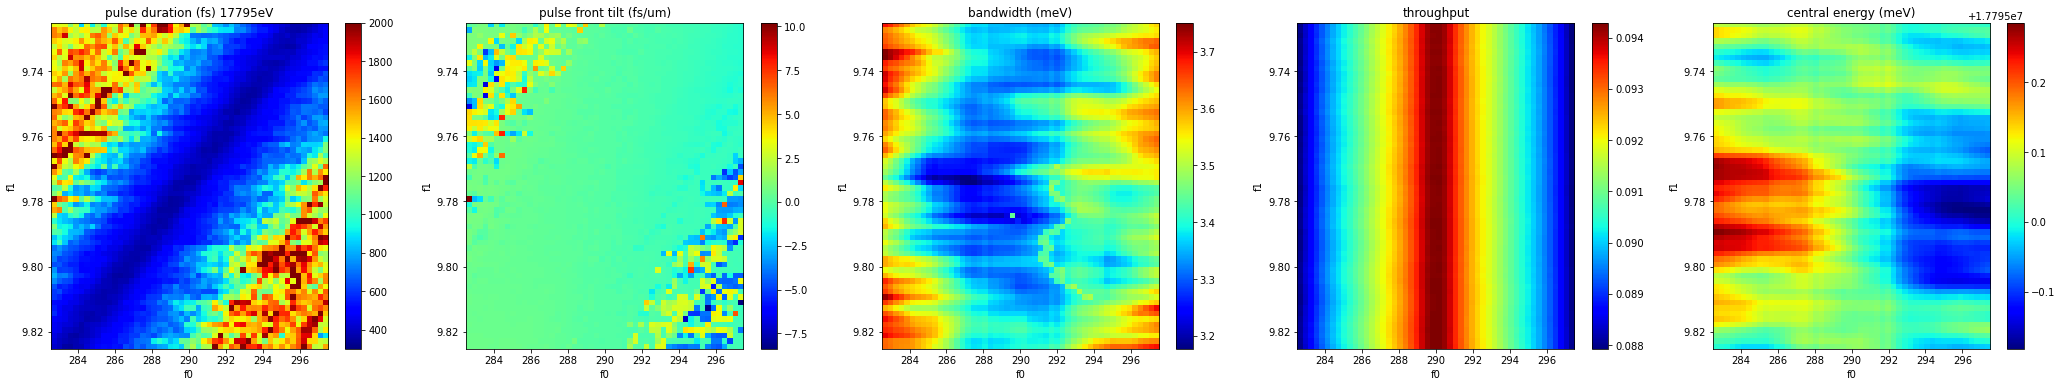

In [10]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'compensation_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

with h5py.File(fig_path+fname+'.h5','r') as f:
    f1_list = f['f1'][:]
    f0_list = f['f0'][:]
    duration = f['duration'][:]
    tilt = f['tilt'][:]
    bw = f['bandwidth'][:]
    throughput = f['throughput'][:]
    cent_E = f['central_energy'][:]

# plot range
plt.figure(figsize=(36,6))
plt.subplot(1,5,1)
plt.imshow(duration, cmap='jet',
          extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.clim([300,2000])
plt.xlabel('f0')
plt.ylabel('f1')
plt.axis('tight')
plt.title('pulse duration (fs) {}eV'.format(E0))

plt.subplot(1,5,2)
plt.imshow(tilt, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0')
plt.ylabel('f1')
plt.axis('tight')
plt.title('pulse front tilt (fs/um)')

plt.subplot(1,5,3)
plt.imshow(bw*1e3, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0')
plt.ylabel('f1')
plt.axis('tight')
plt.title('bandwidth (meV)')

plt.subplot(1,5,4)
plt.imshow(throughput, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0')
plt.ylabel('f1')
plt.axis('tight')
plt.title('throughput')

plt.subplot(1,5,5)
plt.imshow(cent_E*1e3, cmap='jet',
           extent = [f0_list.min(), f0_list.max(), f1_list.max(), f1_list.min()])
plt.colorbar()
plt.xlabel('f0')
plt.ylabel('f1')
plt.axis('tight')
plt.title('central energy (meV)')

plt.savefig(fig_path+fname+'.png')